In [ ]:
__author__ = 'Elliot I. Simon'
__email__ = 'ellsim@dtu.dk'
__version__ = 'October 18, 2021'

This program processes the Globe offshore tilt measurements during installation to find the offsets representing the zero-tilt position

In [ ]:
import os
import zipfile
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
#from scipy.signal import periodogram
import glob

In [ ]:
%matplotlib notebook
#%matplotlib inline

In [ ]:
pd.options.display.float_format = '{:.5f}'.format
plt.rcParams['figure.figsize'] = [10, 8]

# Data loading/processing

In [ ]:
!pwd

In [ ]:
# Give system name
sys = 'Globe5'

In [ ]:
inpath = r'M:\Documents\GloBE\Motion_sensor_zero_calibration\Globe5'

In [ ]:
outpath = 'M:\\Documents\\GloBE\\Motion_sensor_zero_calibration\\Globe5\\'

In [ ]:
# Globe #3 doesn't have the Gyro. All the rest do
if sys == 'Globe3':
    numchannels = 11
else:
    numchannels = 26

In [ ]:
# Find all zipfiles in path
zipfiles = glob.glob(inpath+'\\*.zip')

In [ ]:
zipfiles

In [ ]:
# Linux method to unzip
!cd ".\tilt_datasample\Globe1_tiltsample\2021\09\22\"
!while [ "`find . -type f -name '*.zip' | wc -l`" -gt 0 ]; do find -type f -name "*.zip" -exec unzip -- '{}' \; -exec rm -- '{}' \;; done

In [ ]:
# Windows method to unzip (only extract .tim files from archive)
for zf in zipfiles:
    with zipfile.ZipFile(zf,"r") as zip_ref:
        [zip_ref.extract(file, path=outpath+'\\bin') for file in zip_ref.namelist() if file.endswith('.tim')]

In [ ]:
#Powershell script code:
#Get-Childitem -File -filter "*.tim" | Foreach {C:\Users\elliot\Documents\GloBE\bin2asc\bin2asc.exe $_.FullName ..\ascii\$_ 14 "%6.3f"}
#Dir ..\ascii\*.tim | rename-item -newname { [io.path]::ChangeExtension($_.name, "txt") }

In [ ]:
binfiles = glob.glob(outpath+'bin\\'+'*.tim')

In [ ]:
binfiles

In [ ]:
# Run binary to ascii conversion on all binary files
for f in binfiles:
    asciifile = f.split('\\')[-1].split('.tim')[0]+'.tsv'
    asciifile = outpath + 'ascii\\' + asciifile
    print(asciifile)
    os.system("bin2asc.exe {0} {1} {2} {3}".format(f, asciifile, numchannels, "%6.3f"))

In [ ]:
# List converted ascii files
tsvfiles = glob.glob(outpath + 'ascii\\' + '*.tsv')
tsvfiles = sorted(([str(f) for f in tsvfiles]))

In [ ]:
tsvfiles

In [ ]:
%%time
df = pd.concat(map(lambda f: pd.read_csv(f, delim_whitespace=True, header=None), tsvfiles))

In [ ]:
# Rename columns to match channel names
if sys == 'Globe3':
    df.columns = ['YY', 'MT', 'DD', 'HH', 'MM', 'SS', 'RTC_MS', 'Temp_inc', 'X_inc', 'Y_inc', 'Inc_stat']
else:
    df.columns = ['YY', 'MT', 'DD', 'HH', 'MM', 'SS', 'RTC_MS', 'Gyro_MS', 'AX', 'AY', 'AZ', 'GX', 'GY', 'GZ', 'HX', 'HY', 'HZ', 
             'Roll', 'Pitch', 'Yaw', 'Temp_gyro', 'Gyro_stat', 'Temp_inc', 'X_inc', 'Y_inc', 'Inc_stat']

In [ ]:
df.head()

In [ ]:
%%time
# Force conversion to int to remove trailing decimals, then force conversion to str to comply with datetime formatter
df['YY'] = df['YY'].astype(int).astype(str)
df['MT'] = df['MT'].astype(int).astype(str)
df['DD'] = df['DD'].astype(int).astype(str)
df['HH'] = df['HH'].astype(int).astype(str)
df['MM'] = df['MM'].astype(int).astype(str)
df['SS'] = df['SS'].astype(int).astype(str)
# Convert to microseconds to use with to_datetime
# Realtime clock from computer
df['RTC_US'] = (df['RTC_MS']*1000).astype(int).astype(str)
# Time from gyro sampling timestamp
#df['Gyro_US'] = (df['Gyro_MS']*1000).astype(int).astype(str)

In [ ]:
# Build datetime string from clock channels
df['dt'] = pd.to_datetime(df['YY'] + '-' + df['MT'] + '-' + df['DD'] + ' ' + 
               df['HH'] + ':' + df['MM'] + ':' + 
               df['SS'] + ':' + df['RTC_US'], 
               format = '%Y-%m-%d %H:%M:%S:%f')
df.set_index(df['dt'], inplace=True)

In [ ]:
# Delete unneeded columns to save space
del df['dt']
del df['RTC_US']
del df['YY']
del df['MT']
del df['DD']
del df['HH']
del df['MM']
del df['SS']

In [ ]:
df.head()

In [ ]:
# Save result to hdf5 file
# Make filename from the time range contained in the dataframe
outfile = str(df.first_valid_index()).split('.')[0].replace(' ','_').replace('-','_').replace(':','_') + '-' + str(df.last_valid_index()).split('.')[0].replace(' ','_').replace('-','_').replace(':','_')
outfile = outpath + 'hdf\\' + sys + '_tiltdata_' + outfile + '.hdf'
print(outfile)
df.to_hdf(outfile, key='df', complib='blosc')

<IPython.core.display.Javascript object>


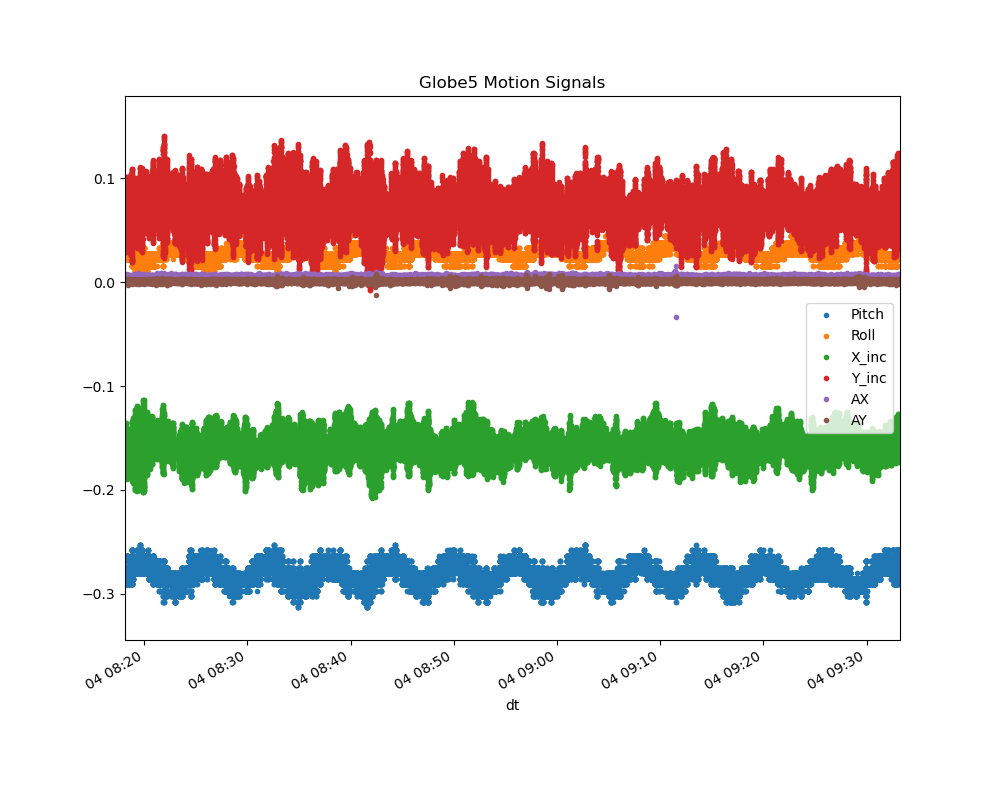

In [18]:
df['Pitch'].plot(linewidth=0, marker='.')
df['Roll'].plot(linewidth=0, marker='.')
df['X_inc'].plot(linewidth=0, marker='.')
df['Y_inc'].plot(linewidth=0, marker='.')
df['AX'].plot(linewidth=0, marker='.')
df['AY'].plot(linewidth=0, marker='.')

#df['GX'].plot(linewidth=0, marker='.')
#df['GY'].plot(linewidth=0, marker='.')
plt.ylim(-2,2)
plt.legend()
plt.title(str(sys) + ' Motion Signals')
plt.savefig(str(sys) + ' Motion Signals No Offsets.png', dpi=300)

In [19]:
#df_cal = df.loc['2021-08-04 12:50:00':'2021-08-04 13:37:00']  #Globe 1
#df_cal = df.loc['2021-08-06 09:22:00':'2021-08-06 10:27:00']  #Globe 2 
#df_cal = df.loc['2021-08-06 08:19:00':'2021-08-06 09:24:00']  #Globe 3
#df_cal = df.loc['2021-08-03 23:04:00':'2021-08-04 01:13:00']  #Globe 4
df_cal = df.loc['2021-08-04 08:18:00':'2021-08-04 09:33:00']   # Globe 5
#df_cal = df.loc['2021-08-05 08:28:00':'2021-08-05 09:35:00']  #Globe 6
# Globe 7

<ipython-input-19-c5c63675cb90>:5: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_cal = df.loc['2021-08-04 08:18:00':'2021-08-04 09:33:00']   # Globe 5


<IPython.core.display.Javascript object>


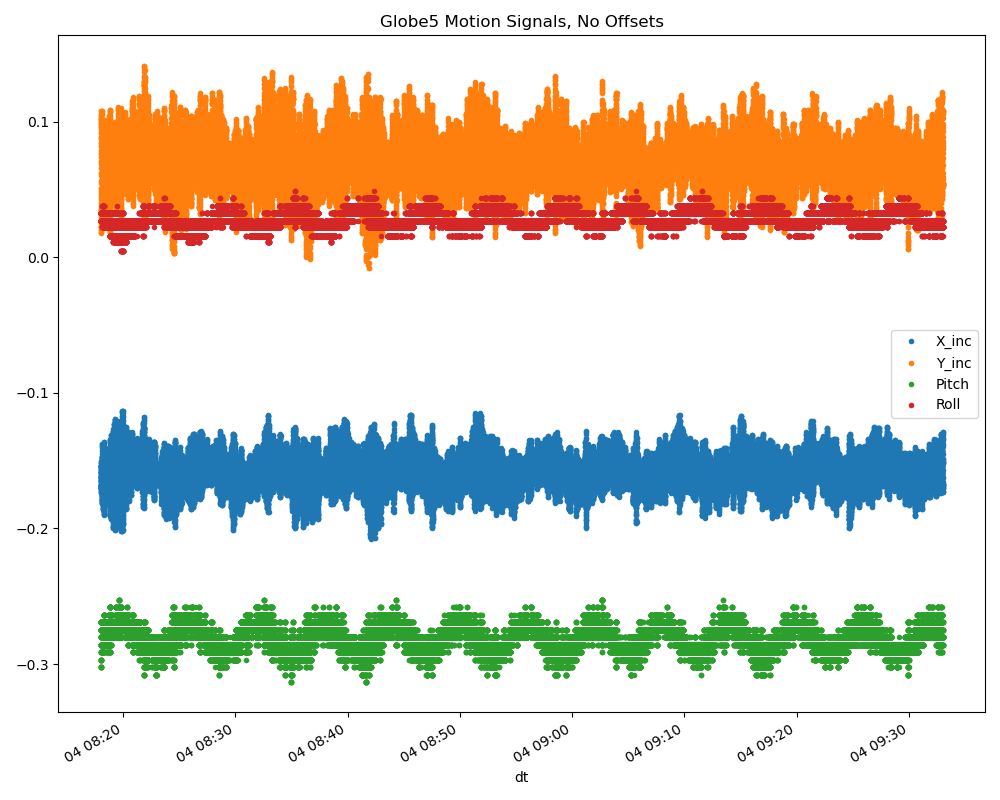

In [20]:
df_cal['X_inc'].plot(linewidth=0, marker='.')
df_cal['Y_inc'].plot(linewidth=0, marker='.')
df_cal['Pitch'].plot(linewidth=0, marker='.')
df_cal['Roll'].plot(linewidth=0, marker='.')
plt.legend()
plt.title(str(sys) + ' Motion Signals, No Offsets')
plt.gcf().tight_layout()
plt.savefig(str(sys) + ' Motion Signals Calibration Period No Offsets.png', dpi=300)

In [21]:
X_inc_offset = df_cal['X_inc'].mean()
Y_inc_offset = df_cal['Y_inc'].mean()
Pitch_offset = df_cal['Pitch'].mean()
Roll_offset = df_cal['Roll'].mean()

print(str(sys) + ' X_inc channel offset = ' + str(X_inc_offset))
print(str(sys) + ' Y_inc channel offset = ' + str(Y_inc_offset))
print(str(sys) + ' Pitch channel offset = ' + str(Pitch_offset))
print(str(sys) + ' Roll channel offset = ' + str(Roll_offset))

Globe5 X_inc channel offset = -0.1583262608309412
Globe5 Y_inc channel offset = 0.07006586036436417
Globe5 Pitch channel offset = -0.28108167629417646
Globe5 Roll channel offset = 0.02836737669406289


In [22]:
df_cal['X_inc'] -= X_inc_offset
df_cal['Y_inc'] -= Y_inc_offset
df_cal['Pitch'] -= Pitch_offset
df_cal['Roll'] -= Roll_offset

<IPython.core.display.Javascript object>


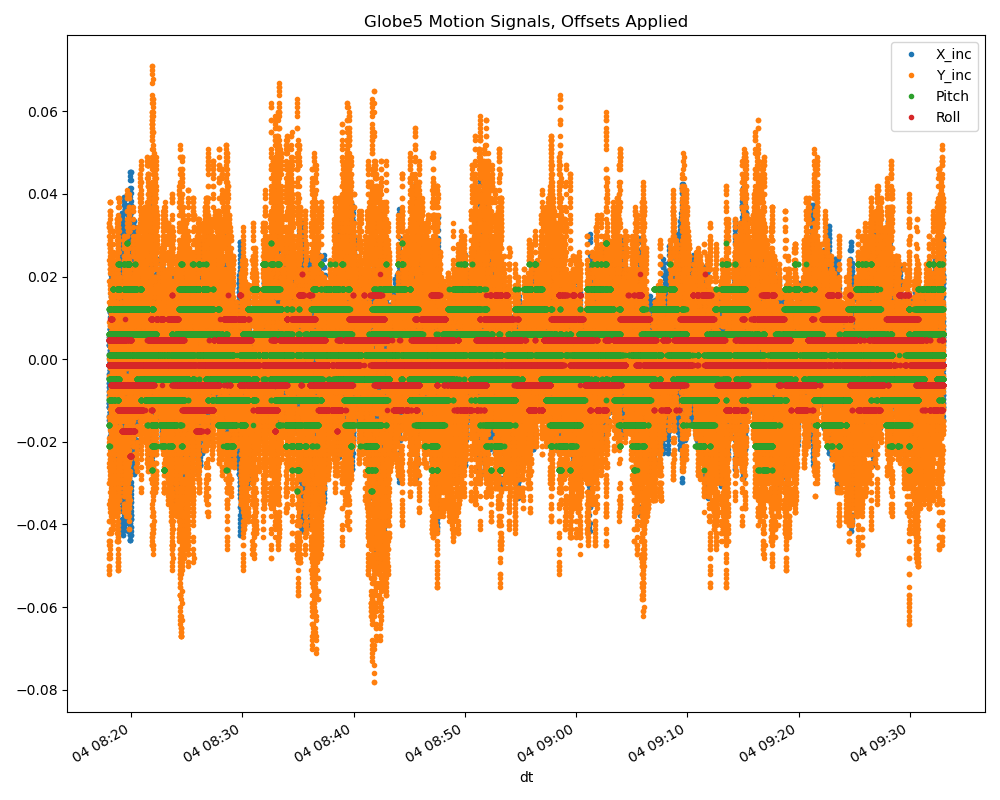

In [23]:
df_cal['X_inc'].plot(linewidth=0, marker='.')
df_cal['Y_inc'].plot(linewidth=0, marker='.')
df_cal['Pitch'].plot(linewidth=0, marker='.')
df_cal['Roll'].plot(linewidth=0, marker='.')
plt.legend()
plt.title(str(sys) + ' Motion Signals, Offsets Applied')
plt.gcf().tight_layout()
plt.savefig(str(sys) + ' Motion Signals Calibration Period Offsets Applied.png', dpi=300)

In [24]:
print(df_cal['X_inc'].describe())
print('_____________________________')
print(df_cal['Y_inc'].describe())
print('_____________________________')
print(df_cal['Pitch'].describe())
print('_____________________________')
print(df_cal['Roll'].describe())

count   72016.00000
mean        0.00000
std         0.01253
min        -0.04967
25%        -0.00867
50%         0.00033
75%         0.00833
max         0.04533
Name: X_inc, dtype: float64
_____________________________
count   72016.00000
mean       -0.00000
std         0.01927
min        -0.07807
25%        -0.01307
50%        -0.00007
75%         0.01293
max         0.07093
Name: Y_inc, dtype: float64
_____________________________
count   72016.00000
mean        0.00000
std         0.00973
min        -0.03192
25%        -0.00492
50%         0.00108
75%         0.00608
max         0.02808
Name: Pitch, dtype: float64
_____________________________
count   72016.00000
mean        0.00000
std         0.00630
min        -0.02337
25%        -0.00637
50%        -0.00137
75%         0.00463
max         0.02063
Name: Roll, dtype: float64


In [25]:
# Save result to hdf5 file
# Make filename from the time range contained in the dataframe
outfile = str(df.first_valid_index()).split('.')[0].replace(' ','_').replace('-','_').replace(':','_') + '-' + str(df.last_valid_index()).split('.')[0].replace(' ','_').replace('-','_').replace(':','_')
outfile = outpath + 'hdf\\' + sys + '_tiltdata_offsetsapplied_' + outfile + '.hdf'
print(outfile)
df_cal.to_hdf(outfile, key='df', complib='blosc')

M:\Documents\GloBE\Motion_sensor_zero_calibration\Globe5\hdf\Globe5_tiltdata_offsetsapplied_2021_08_02_02_45_11-2021_08_07_00_00_11.hdf
